In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('default')
from spacepy import pycdf

from numpy import pi,sqrt,sin,cos,arcsin,arccos,dot,rad2deg,arctan,exp,cross
from scipy.special import erf,iv
from tqdm import tqdm
from tletools import TLE
from scipy.interpolate import splrep,splev
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
%matplotlib widget

C:\Users\soumy\anaconda3\lib\site-packages\spacepy\time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
days = mdates.DateLocator()   # date
daysFmt = mdates.DateFormatter('%d')
hoursFmt = mdates.DateFormatter('%H:%M')

In [3]:
start=dt.datetime(2015,6,1); stop=dt.datetime(2015,7,1);
sat='CNOFS'

R_const = 8.31
k_B = 1.38 * (10**-23)
m_O=16; m_O2=32; m_N=14; m_N2=28; m_H=1; m_He=4;

R_O = (R_const/m_O)*1000;
R_N = (R_const/m_N)*1000;
R_O2 = (R_const/m_O2)*1000;
R_N2 = (R_const/m_N2)*1000;
R_He = (R_const/m_He)*1000;
R_H = (R_const/m_H)*1000;

m_cnofs = 384
m_p = 1.672e-27
n0 = 1.0e14

In [4]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)

filename = sat + '_IVM_' + start.strftime("%Y-%m-%d") + '.csv'
CNOFS_Data = pd.read_csv(filename)
CNOFS_Data.index = pd.DatetimeIndex(CNOFS_Data['Unnamed: 0'])
CNOFS_Data=CNOFS_Data.loc[start:stop]

In [6]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_MSIS = pd.read_csv(sat+'_MSIS_jl_'+start.strftime("%Y-%m-%d")+'.csv')
Data_MSIS.index=pd.DatetimeIndex(Data_MSIS['Unnamed: 0'])
Data_MSIS = Data_MSIS.loc[start:stop]
# n0 = np.mean(Data_MSIS.iloc[:,2:8].sum(axis=1))

In [7]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "gitm_cnofs_int_2015-06-22.csv"
Data_GITM = pd.read_csv(filename)
Data_GITM.index=pd.DatetimeIndex(Data_GITM["Unnamed: 0"])
Data_GITM = Data_GITM.drop(columns="Unnamed: 0")

In [39]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\SPDF\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/SPDF/'
os.chdir(filepath)
filename = 'cnofs_20230324001816_147222.cdf';
cdf = pycdf.CDF(filename) 
time_array = pd.DatetimeIndex(cdf['Epoch'])
XYZ_TOD = pd.DataFrame(cdf['XYZ_TOD'],columns = ['X','Y','Z'],index = time_array)
XYZ_TOD = XYZ_TOD.loc[start:stop]
RADIUS = pd.DataFrame({'Radius' : list(cdf['RADIUS'])},index = time_array)


In [9]:
Z = XYZ_TOD['Z']
idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
orbit_end = Z.index[idxz] 
time_avg = np.array([orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)])

In [12]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/'
os.chdir(filepath)
filename = "omni_min_dhu3NtEmPj.txt"
SW_Data_min = np.loadtxt(filename,dtype = float)
time_array = pd.DatetimeIndex([dt.datetime(int(SW_Data_min[:,0][i]),1,1,0,0,0) +
               dt.timedelta(days = SW_Data_min[:,1][i]-1) +
               dt.timedelta(hours = SW_Data_min[:,2][i]) + dt.timedelta(minutes = SW_Data_min[:,3][i])
                               for i in range(len(SW_Data_min))])

SW_Data_min = pd.DataFrame(SW_Data_min)
SW_Data_min.columns = ['Year','DOY','Hour','Minutes','B0','Bx','By','Bz','flow speed','flow pressure','electric field',
                     'AE','AL','AU','SYM/H','PCN']
SW_Data_min.index = pd.DatetimeIndex(time_array)
SW_Data_min = SW_Data_min.loc[start:stop]


In [5]:
c=1/sqrt(2); c1=0.96592583; c2=0.25881905; c3=0.6830127;
theta = pi/10;
a = [0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,
    0.579,0.579,0.579,0.579,0.579,0.579,0.579,0.579,
    0.142,0.142,0.142,0.142,0.142,0.142,0.142,0.142,
    0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,
    0.455,1];
    # 0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078, 
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,
    # 0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924];

n_a = [(1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (c1,-c2,0),(c3,-c2,c3),(0,-c2,c1),(-c3,-c2,c3),(-c1,-c2,0),(-c3,-c2,-c3),(0,-c2,-c1),(c3,-c2,-c3),
      (cos(-theta),0,sin(-theta)),(cos(-3*theta),0,sin(-3*theta)),(cos(-5*theta),0,sin(-5*theta)),(cos(-7*theta),0,sin(-7*theta)),(cos(-9*theta),0,sin(-9*theta)),
      (cos(-11*theta),0,sin(-11*theta)),(cos(-13*theta),0,sin(-13*theta)),(cos(-15*theta),0,sin(-15*theta)),(cos(-17*theta),0,sin(-17*theta)),
       (cos(-19*theta),0,sin(-19*theta)),(0,-1,0),(0,1,0)];
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 1
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 2
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 3
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 4
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c), ## boom 5
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c)]; ## boom 6


In [6]:
def sigma_n(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    alpha_n = 2*alpha - 1
    if alpha_n < 0:
        alpha_n = 0
    return 1 - sqrt(1-alpha_n)

def alpha(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    return alpha

def theta(key,temp,nO):
    k_B = 1.38e-23
    P_O = nO*k_B*temp ## partial pressure of O
    if key == "DRIA":
        K = 1.44e6;        
    elif key == "CLL":
        K = 2.89e6;
    th = K*P_O/(1 + K*P_O)
    return th

def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between surface normal and velocity vector
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    mu = g*s 
    c1 = sigma_t*(1 - g**2)*gamma1(mu)
    c2 = (2-sigma_n)*g*gamma2(mu)/s
    c3 = sigma_n*(v_w/v)*gamma1(mu)*g
    return (2/s)*(c1+c2+c3)

def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2

def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2

def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
    return C_D

def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2

def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2

In [68]:
drag_CLL_plane(7500,519,1100,pi/4,1,1,300)

1.4945059820943811

In [69]:
drag_CLL_cyl(7500,519,1100,pi/4,1,1,300)

1.4946358506748414

In [7]:
def CNOFS_area(v,a,n_a):
    area=0;r_probe = 0.06; r_boom = 0.0143;
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    area += 1.3259 ## booms and probes added
    return area

def drag_CNOFS_CLL(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    sn = sigma_n(m_atm,60)
    th = theta("CLL",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_CLL_plane(v_abs,R,temp,angle,1,1,T_s)*a[i]
        CD_CL += drag_CLL_plane(v_abs,R,temp,angle,1,sn,T_s)*a[i]
    
    CD_CO += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,1,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,sn,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_CLL_cyl(v_abs,R,temp,pi/2,1,1,T_s)*2*r_boom*18.02
    CD_CL += drag_CLL_cyl(v_abs,R,temp,pi/2,1,sn,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_CLL_sphere(v_abs,R,temp,1,1,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_CLL_sphere(v_abs,R,temp,1,sn,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D
    
def drag_CNOFS_DRIA(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    alpha_ads = 1.0;
    alpha_s = alpha(m_atm,60)
    th = theta("DRIA",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_DRIA_plane(v_abs,R,temp,angle,alpha_ads,T_s)*a[i]
        CD_CL += drag_DRIA_plane(v_abs,R,temp,angle,alpha_s,T_s)*a[i]
    
    CD_CO += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_ads,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_s,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_ads,T_s)*2*r_boom*18.02
    CD_CL += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_s,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_ads,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_s,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D

In [29]:
V = np.array(list(zip(CNOFS_Data['scRELvelocityX']*1000,CNOFS_Data['scRELvelocityY']*1000,CNOFS_Data['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

# MSIS

In [13]:
mole_frac = pd.DataFrame({'O':[Data_MSIS['nO'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N':[Data_MSIS['nN'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         'O2':[Data_MSIS['nO2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N2': [Data_MSIS['nN2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'He': [Data_MSIS['nHe'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'H': [Data_MSIS['nH'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         },index = Data_MSIS.index);
mole_frac_msis = mole_frac

100%|████████████████████████████████████████████████████████████████████████████| 5725/5725 [00:01<00:00, 4654.89it/s]


In [14]:
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']

In [15]:
N=len(CNOFS_Data); C_D = [];Area = [];
drag_coeff = np.zeros((N,7))
for i in tqdm(range(N)):
    v = V[i];
    temp = Data_MSIS['Tz'][i];
    m_atm = m_avg[i];
    nO = Data_MSIS['nO'][i];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_MSIS_CLL = C_D;  
CD_MSIS_CLL=pd.DataFrame({"C_D":CD_MSIS_CLL,'A':area},index=CNOFS_Data.index)
CD_MSIS_CLL_orbit = np.array([CD_MSIS_CLL['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)])

100%|██████████████████████████████████████████████████████████████████████████████| 5725/5725 [03:05<00:00, 30.80it/s]


In [16]:
N=len(CNOFS_Data); C_D = [];Area = [];
drag_coeff = np.zeros((N,7))
for i in tqdm(range(N)):
    v = V[i];
    temp = Data_MSIS['Tz'][i];
    m_atm = m_avg[i];
    nO = Data_MSIS['nO'][i];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_MSIS_DRIA = C_D;  
CD_MSIS_DRIA=pd.DataFrame({"C_D":CD_MSIS_DRIA,'A':area},index=CNOFS_Data.index)
CD_MSIS_DRIA_orbit = np.array([CD_MSIS_DRIA['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)])

100%|██████████████████████████████████████████████████████████████████████████████| 5725/5725 [01:11<00:00, 79.64it/s]


In [17]:
idx = np.where(~np.isnan(CD_MSIS_CLL_orbit))[0]
time_avg = time_avg[idx]
CD_MSIS_CLL_orbit = CD_MSIS_CLL_orbit[idx]
CD_MSIS_DRIA_orbit = CD_MSIS_DRIA_orbit[idx]
CLL_mean = uniform_filter1d(CD_MSIS_CLL_orbit,5)
err = CD_MSIS_CLL_orbit - CLL_mean
idx = np.where(abs(zscore(err))>3.0)[0]
for idx0 in idx:
    CD_MSIS_CLL_orbit[idx0] = CLL_mean[idx0]
DRIA_mean = uniform_filter1d(CD_MSIS_DRIA_orbit,5)
err = CD_MSIS_DRIA_orbit - DRIA_mean
idx = np.where(abs(zscore(err))>3.0)[0]
for idx0 in idx:
    CD_MSIS_DRIA_orbit[idx0] = DRIA_mean[idx0]

# GITM

In [18]:
# df1 = CNOFS_Data.loc[dt.datetime(2015,6,22):dt.datetime(2015,6,26)]
df1 = CNOFS_Data.iloc[1:,:]
V = np.array(list(zip(df1['scRELvelocityX']*1000,df1['scRELvelocityY']*1000,df1['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])
orbit_end_sel = orbit_end[(orbit_end>=dt.datetime(2015,6,22))&(orbit_end<=dt.datetime(2015,6,26))]
time_avg_sel = [orbit_end_sel[i] + (orbit_end_sel[i+1] - orbit_end_sel[i])/2 for i in range(len(orbit_end_sel)-1)]

In [19]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "gitm_cnofs_int_2015-06-22.csv"
Data_GITM = pd.read_csv(filename)
Data_GITM.index=pd.DatetimeIndex(Data_GITM["Unnamed: 0"])
Data_GITM = Data_GITM.drop(columns="Unnamed: 0")

In [48]:
nO = Data_GITM['O(!U3!NP)'] + Data_GITM['O(!U1!ND)'] 
nO2 = Data_GITM['O!D2!N']
nN = Data_GITM['N(!U2!ND)'] + Data_GITM['N(!U2!NP)'] + Data_GITM['N(!U4!NS)']
nN2 = Data_GITM['N!D2!N']
nHe = Data_GITM['He']
nH = Data_GITM['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm=mole_frac
# mole_fracO_orbit_gitm = np.array([mole_frac['O'][(mole_frac.index>=orbit_end[i])&(mole_frac.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)])

In [21]:
N=len(df1); C_D = [];Area = [];
drag_coeff = np.zeros((N,7));
for i in tqdm(range(N)):
    v = V[i];
    temp = Data_GITM['Temperature'][i];
    m_atm = m_avg[i];
    n_O = nO[i];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL = C_D;  
CD_GITM_CLL=pd.DataFrame({"C_D":CD_GITM_CLL,'A':area},index=df1.index)
CD_GITM_CLL_orbit = [CD_GITM_CLL['C_D'][(CD_GITM_CLL.index>=orbit_end_sel[i])&(CD_GITM_CLL.index<=orbit_end_sel[i+1])].mean() for i in range(len(orbit_end_sel)-1)]

100%|██████████████████████████████████████████████████████████████████████████████| 5724/5724 [03:13<00:00, 29.58it/s]


In [22]:
N=len(df1); C_D = [];Area = [];
drag_coeff = np.zeros((N,7))
for i in tqdm(range(N)):
    v = V[i];
    temp = Data_GITM['Temperature'][i];
    m_atm = m_avg[i];
    n_O = nO[i];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_DRIA = C_D;  
CD_GITM_DRIA=pd.DataFrame({"C_D":CD_GITM_DRIA,'A':area},index=df1.index)
CD_GITM_DRIA_orbit = [CD_GITM_DRIA['C_D'][(CD_GITM_DRIA.index>=orbit_end_sel[i])&(CD_GITM_DRIA.index<=orbit_end_sel[i+1])].mean() for i in range(len(orbit_end_sel)-1)]

100%|██████████████████████████████████████████████████████████████████████████████| 5724/5724 [01:12<00:00, 78.89it/s]


In [23]:
CD_GITM_CLL_avg = uniform_filter1d(CD_GITM_CLL['C_D'],100)
CD_MSIS_CLL_avg = uniform_filter1d(CD_MSIS_CLL['C_D'],100)
CD_GITM_DRIA_avg = uniform_filter1d(CD_GITM_DRIA['C_D'],100)
CD_MSIS_DRIA_avg = uniform_filter1d(CD_MSIS_DRIA['C_D'],100)

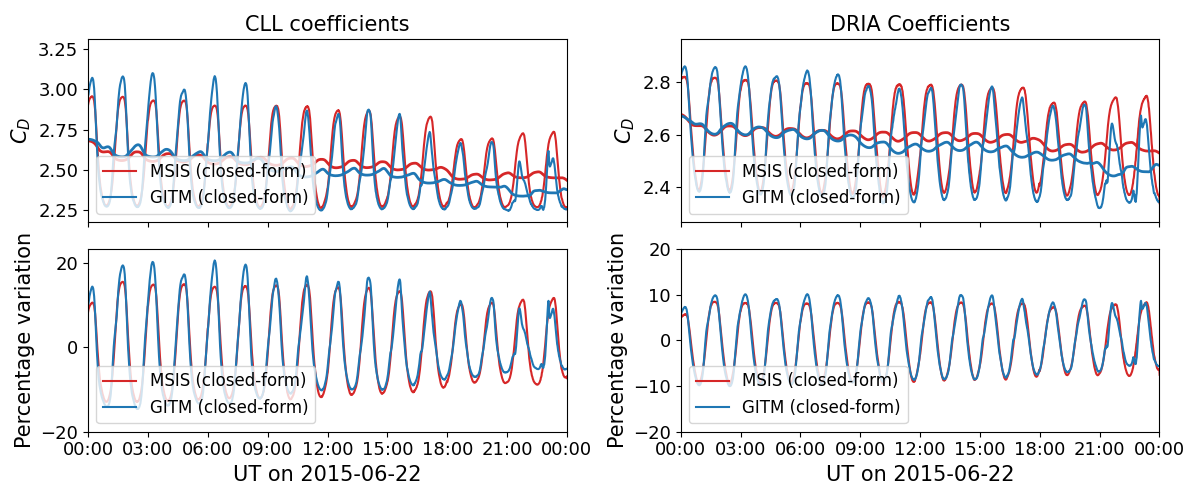

In [36]:
fig,ax = plt.subplots(2,2,figsize=[12,5],sharex=True)

ax[0,0].plot(CD_MSIS_CLL['C_D'],label='MSIS (closed-form)',c='tab:red',lw=1.5)
ax[0,0].plot(CD_MSIS_CLL.index,CD_MSIS_CLL_avg,'-',c='tab:red',lw=2)

# ax[0,0].plot(CD_MSIS_CLL['C_D'],'-',label='MSIS (closed form)',ms=5,c='tab:red',lw=1.5)

ax[0,0].plot(CD_GITM_CLL['C_D'],label = 'GITM (closed-form)',c='tab:blue',lw=1.5)
ax[0,0].plot(CD_GITM_CLL.index,CD_GITM_CLL_avg,'-',c='tab:blue',lw=2)

# ax[0,0].plot(CD_GITM_CLL['C_D'],'-',label='GITM (closed form)',ms=5,c='tab:blue',lw=1.5)
# ax[0,0].plot(RSM_CD_GITM_CLL.index,RSM_CD_GITM_CLL_avg,'-',c='tab:blue',lw=2)

ax[0,0].set_xlim([start,start+dt.timedelta(days=1)]);
# ax[0,0].set_ylim([3.0,5.0])
ax[0,0].set_ylabel("$C_{D}$",fontsize=15)
ax[0,0].legend(fontsize=12,loc='lower left')
ax[0,0].tick_params(labelsize=13)
ax[0,0].xaxis.set_major_formatter(hoursFmt);
ax[0,0].set_title("CLL coefficients",fontsize=15)

# ax[1,0].plot((RSM_CD_MSIS_CLL['C_D']-RSM_CD_MSIS_CLL_avg)*100/RSM_CD_GITM_CLL_avg,label='MSIS (RSM)',c='tab:red',lw=1.5)
# ax[1,0].plot((RSM_CD_GITM_CLL['C_D']-RSM_CD_GITM_CLL_avg)*100/RSM_CD_GITM_CLL_avg,label = 'GITM (RSM)',c='tab:blue',lw=1.5)
ax[1,0].plot((CD_MSIS_CLL['C_D']-CD_MSIS_CLL_avg)*100/CD_MSIS_CLL_avg,'-',label='MSIS (closed-form)',c='tab:red',lw=1.5)
ax[1,0].plot((CD_GITM_CLL['C_D']-CD_GITM_CLL_avg)*100/CD_GITM_CLL_avg,'-',label = 'GITM (closed-form)',c='tab:blue',lw=1.5)


ax[1,0].set_xlim([start,start+dt.timedelta(days=1)]);
ax[1,0].set_yticks([-20,0,20])
ax[1,0].set_xlabel("UT on "+start.strftime("%Y-%m-%d"),fontsize=15)
ax[1,0].set_ylabel("Percentage variation",fontsize=15)
ax[1,0].legend(fontsize=12,loc='lower left')
ax[1,0].tick_params(labelsize=13)
ax[1,0].xaxis.set_major_formatter(hoursFmt);


ax[0,1].plot(CD_MSIS_DRIA.index, CD_MSIS_DRIA['C_D'],label='MSIS (closed-form)',c='tab:red',lw=1.5)
ax[0,1].plot(CD_MSIS_DRIA.index,CD_MSIS_DRIA_avg,'-',c='tab:red',lw=2)
# ax[0,1].plot(CD_MSIS_DRIA['C_D'],'-',label='MSIS (closed form)',ms=5,c='tab:red',lw=1.5)
ax[0,1].plot(CD_GITM_DRIA['C_D'],label = 'GITM (closed-form)',c='tab:blue',lw=1.5)
ax[0,1].plot(CD_GITM_DRIA.index,CD_GITM_DRIA_avg,'-',c='tab:blue',lw=2)


# ax[0,1].plot(CD_GITM_DRIA['C_D'],'-',label='GITM (closed form)',ms=5,c='tab:blue',lw=1.5)

ax[0,1].set_xlim([start,start+dt.timedelta(days=1)]);
# ax[0,1].set_ylim([3.0,5.0])
ax[0,1].set_ylabel("$C_{D}$",fontsize=15)
ax[0,1].legend(fontsize=12,loc='lower left')
ax[0,1].tick_params(labelsize=13)
ax[0,1].xaxis.set_major_formatter(hoursFmt);
ax[0,1].set_title("DRIA Coefficients",fontsize=15)

ax[1,1].plot(CD_MSIS_DRIA.index,(CD_MSIS_DRIA['C_D']-CD_MSIS_DRIA_avg)*100/CD_MSIS_DRIA_avg,label='MSIS (closed-form)',c='tab:red',lw=1.5)
ax[1,1].plot(CD_GITM_DRIA.index,(CD_GITM_DRIA['C_D']-CD_GITM_DRIA_avg)*100/CD_GITM_DRIA_avg,label = 'GITM (closed-form)',c='tab:blue',lw=1.5)
# # ax[1,1].plot((CD_MSIS_DRIA['C_D']-CD_MSIS_DRIA_avg)*100/CD_MSIS_DRIA_avg,'-',label='MSIS (closed form)',c='tab:red',lw=1.5)
# # ax[1,1].plot((CD_GITM_DRIA['C_D']-CD_GITM_DRIA_avg)*100/CD_GITM_DRIA_avg,'-',label = 'GITM (closed form)',c='tab:blue',lw=1.5)

ax[1,1].set_xlim([start,start+dt.timedelta(days=1)]);
ax[1,1].set_yticks([-20,-10,0,10,20])
ax[1,1].set_xlabel("UT on "+start.strftime("%Y-%m-%d"),fontsize=15)
ax[1,1].set_ylabel("Percentage variation",fontsize=15)
ax[1,1].legend(fontsize=12,loc='lower left')
ax[1,1].tick_params(labelsize=13)
ax[1,1].xaxis.set_major_formatter(hoursFmt);



plt.tight_layout()

filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
filename = "CNOFSCLL.jpg"
plt.savefig(filename,dpi=300)

plt.show()


In [25]:
O_MSIS_orbit = [mole_frac_msis['O'][(mole_frac_msis.index>=orbit_end[i])&(mole_frac_msis.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]
O_GITM_orbit = [mole_frac_gitm['O'][(mole_frac_gitm.index>=orbit_end[i])&(mole_frac_gitm.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]
Tz_MSIS_orbit = [Data_MSIS['Tz'][(mole_frac_msis.index>=orbit_end[i])&(mole_frac_msis.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]
Tz_GITM_orbit = [Data_GITM['Temperature'][(mole_frac_gitm.index>=orbit_end[i])&(mole_frac_gitm.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


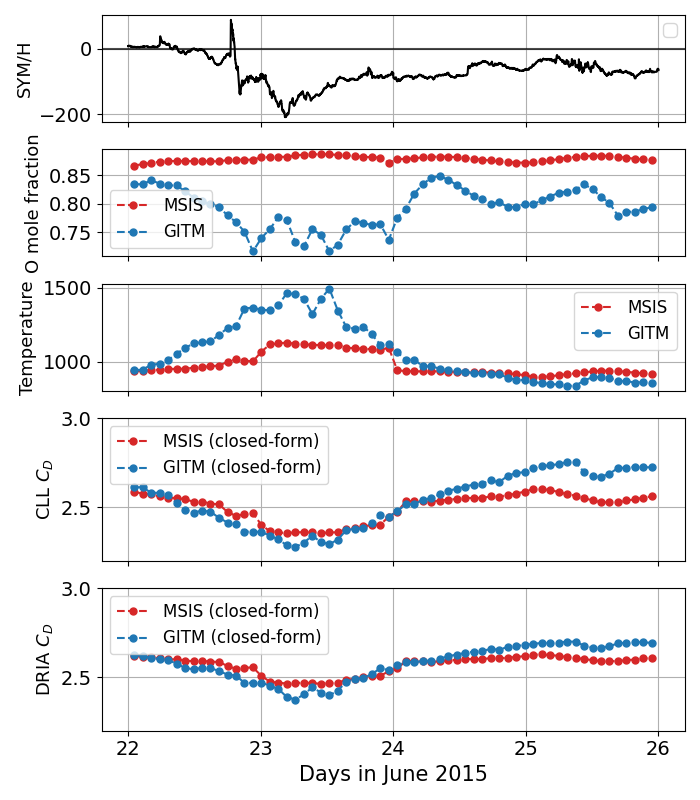

In [35]:
fig,ax = plt.subplots(5,1,figsize=[7,8], gridspec_kw={'height_ratios': [1.5,1.5,1.5,2,2]},sharex=True)

# ax[0].plot(SW_Data_min['Bz'][(SW_Data_min['Bz']<9000)],c='k')
# ax[0].axhline(y=0,ls='-',c='k',alpha=0.7)
# ax[0].set_ylabel('IMF $B_{z}$',fontsize=12)

ax[0].plot(SW_Data_min['SYM/H'][(SW_Data_min['SYM/H']<9000)],c='k')
ax[0].axhline(y=0,ls='-',c='k',alpha=0.7)
ax[0].set_ylabel('SYM/H',fontsize=13)

ax[1].plot(time_avg,O_MSIS_orbit,'--o',ms=5,c='tab:red',label='MSIS')
ax[1].plot(time_avg,O_GITM_orbit,'--o',ms=5,c='tab:blue',label='GITM')
ax[1].set_ylabel('O mole fraction',fontsize=13)

ax[2].plot(time_avg,Tz_MSIS_orbit,'--o',ms=5,c='tab:red',label='MSIS')
ax[2].plot(time_avg,Tz_GITM_orbit,'--o',ms=5,c='tab:blue',label='GITM')
ax[2].set_ylabel('Temperature',fontsize=13)

ax[3].plot(time_avg,CD_MSIS_CLL_orbit,'--o',ms=5,c='tab:red',label='MSIS (closed-form)')
# ax[3].plot(time_avg,RSM_CD_MSIS_CLL_orbit,'-',c='tab:red',lw=2,label='MSIS (RSM)')
ax[3].plot(time_avg,CD_GITM_CLL_orbit,'--o',ms=5,c='tab:blue',label='GITM (closed-form)')
# ax[3].plot(time_avg,RSM_CD_GITM_CLL_orbit,'-',c='tab:blue',lw=2,label='GITM (RSM)')
ax[3].set_ylabel('CLL $C_{D}$',fontsize=13)
ax[3].set_ylim([2.2,3.0])

ax[4].plot(time_avg,CD_MSIS_DRIA_orbit,'--o',ms=5,c='tab:red',label='MSIS (closed-form)')
# ax[4].plot(time_avg,RSM_CD_MSIS_DRIA_orbit,'-',c='tab:red',lw=2,label='MSIS (RSM)')
ax[4].plot(time_avg,CD_GITM_DRIA_orbit,'--o',ms=5,c='tab:blue',label='GITM (closed-form)')
# ax[4].plot(time_avg,RSM_CD_GITM_DRIA_orbit,'-',c='tab:blue',lw=2,label='GITM (RSM)')
ax[4].set_ylabel('DRIA $C_{D}$',fontsize=13)
ax[4].tick_params(labelsize=12)
ax[4].set_ylim([2.2,3.0])

for i in range(5):
    ax[i].set_xticks([start+dt.timedelta(days=i) for i in range(5)])
    ax[i].xaxis.set_major_formatter(daysFmt);
    ax[i].legend(fontsize=12,loc='best')
    ax[i].tick_params(labelsize=14)
    ax[i].grid(axis='both',which='both')
plt.xlabel("Days in June 2015",fontsize=15)
plt.tight_layout()


filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
filename = "CNOFS_CD_CLL_orbit.jpg"
plt.savefig(filename,dpi=300)
plt.show()



# READ TLE

In [55]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\TLE\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/TLE/'
os.chdir(filepath)
filename = 'CNOFS.txt'
f = open(filename,'r')
Data = f.readlines()
f.close()

In [56]:
epochs = []; bstar = [];mean_motion = [];dn_o2=[]; delta_d=1.5;
for i in range(int(len(Data)/2)):
    tle_str = 'CNOFS\n' + Data[2*i] + Data[2*i + 1]
    tle_str = tle_str.strip().splitlines()
    tle = TLE.from_lines(*tle_str)
    epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
    bstar.append(tle.bstar)
    mean_motion.append(tle.n)
    dn_o2.append(tle.dn_o2)
epochs = pd.DatetimeIndex(epochs)
idx0 = np.where(epochs <= start + dt.timedelta(days=delta_d))[0][-1]
idx1 = np.where(epochs >= stop)[0][0]
idx = list(range(idx0,idx1))
fdg = epochs[idx]; DT = np.array([(fdg[i+1]-fdg[i])/dt.timedelta(seconds=1) for i in range(len(fdg)-1)]);
stu = list(np.where(DT == 0.0)[0]);
idx = [j for i, j in enumerate(idx) if i not in stu];
epochs = epochs[idx];
bstar = [bstar[idx0] for idx0 in idx]; 
mean_motion=[mean_motion[idx0] for idx0 in idx]; 
dn_o2=[dn_o2[idx0] for idx0 in idx];

# calculate $\Delta n_{M}^{2/3}$

In [57]:
rev2rad = 2*pi/86400; rev2rad2= rev2rad/86400;
n = np.array(mean_motion)*rev2rad;
dn = np.diff(n);
dn_dt = np.array(dn_o2)*2*rev2rad2;

In [58]:
bal_coeff_CLL = pd.DataFrame([CD_MSIS_CLL['C_D'][i]*CD_MSIS_CLL['A'][i]/m_cnofs for i in range(len(CD_MSIS_CLL))],index=CNOFS_Data.index,columns=['B'])
bal_coeff_DRIA = pd.DataFrame([CD_MSIS_DRIA['C_D'][i]*CD_MSIS_DRIA['A'][i]/m_cnofs for i in range(len(CD_MSIS_DRIA))],index=CNOFS_Data.index,columns=['B'])

mu = 3.986*10**14

In [59]:
dn_m = []; n_est=[]; n0=n[0];n_i = n0;n_est.append(n0);
for i in range(len(epochs)-1):
    t_i = epochs[i]
    t_k = epochs[i+1]
    idx = np.where((CNOFS_Data.index>=t_i)&(CNOFS_Data.index<=t_k))[0]
    dnm_dt= [];time_array=[];
    for idx0 in idx:
        rho=Data_MSIS['rho'][idx0];
        v=np.sqrt(np.sum(V[idx0]**2));
        B=bal_coeff_CLL['B'][idx0];
        dnm_dt.append(rho * B * v**3)
        time_array.append((CNOFS_Data.index[idx0]-t_i)/dt.timedelta(seconds=1))
    n_k = (n_i**(2/3) + np.trapz(dnm_dt,x=time_array)*(mu**(-2/3)))**(3/2)
    n_est.append(n_k)
    dn_m.append(n_k-n_i)
    n_i = n_k
    
n_est_CLL = n_est

In [60]:
dn_m = []; n_est=[]; n0=n[0];n_i = n0;n_est.append(n0);
for i in range(len(epochs)-1):
    t_i = epochs[i]
    t_k = epochs[i+1]
    idx = np.where((CNOFS_Data.index>=t_i)&(CNOFS_Data.index<=t_k))[0]
    dnm_dt= [];time_array=[];
    for idx0 in idx:
        rho=Data_MSIS['rho'][idx0];
        v=np.sqrt(np.sum(V[idx0]**2));
        B=bal_coeff_DRIA['B'][idx0];
        dnm_dt.append(rho * B * v**3)
        time_array.append((CNOFS_Data.index[idx0]-t_i)/dt.timedelta(seconds=1))
    n_k = (n_i**(2/3) + np.trapz(dnm_dt,x=time_array)*(mu**(-2/3)))**(3/2)
    n_est.append(n_k)
    dn_m.append(n_k-n_i)
    n_i = n_k
    
n_est_DRIA = n_est

In [61]:
ylim = [0.0011305,0.0011335]
err = (n_est - n)/(ylim[1]-ylim[0])

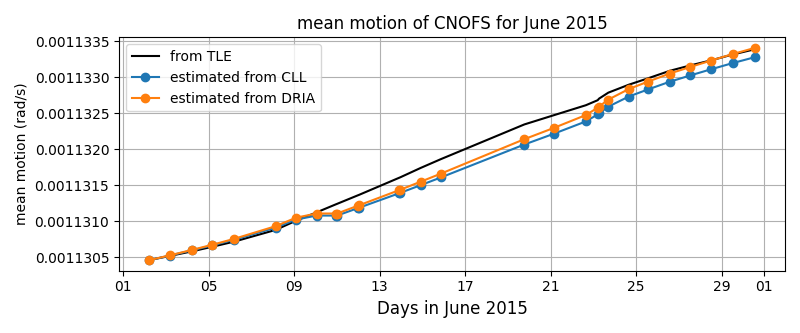

In [62]:
fig,ax1 = plt.subplots(1,1,figsize=[8,3.33],sharex = True,dpi=100)
ax1.plot(epochs,n,'-',label='from TLE',c='k')
ax1.plot(epochs,n_est_CLL,'-o',label='estimated from CLL')
ax1.plot(epochs,n_est_DRIA,'-o',label='estimated from DRIA')

# plt.plot(epochs,n_est_1,'-o',label='estimated',c='green')
ax1.legend()
ax1.set_ylabel('mean motion (rad/s)')
ax1.set_title('mean motion of CNOFS for June 2015')
ax1.xaxis.set_major_formatter(daysFmt);
ax1.set_xlabel('Days in June 2015',fontsize=12);

# ax1[1].plot(epochs,n_est_CLL-n,label = 'CLL est. - TLE',c='tab:red')
# ax1[1].plot(epochs,n_est_DRIA-n,label = 'DRIA est. - TLE',c='tab:blue')
# ax1[1].axhline(y=0,ls='--',lw=1.5,c='k')
# ax1[1].legend(loc='upper left')
ax1.grid()
plt.tight_layout()
plt.show()
# ax2 = ax1.twinx()
# ax2.plot(epochs,err*100,'--o',c='k')
# ax2.set_ylabel('Error in mean motion')


In [63]:
idx = np.where(np.diff(n_est_CLL) < 1e-10)[0]
for idx0 in idx:
    fix = n_est_CLL[idx0]-n_est_CLL[idx0-1]
    n_est_CLL[idx0+1:] = n_est_CLL[idx0+1:] + fix 
    
idx = np.where(np.diff(n_est_DRIA) < 1e-10)[0]
for idx0 in idx:
    fix = n_est_DRIA[idx0]-n_est_DRIA[idx0-1]
    n_est_DRIA[idx0+1:] = n_est_DRIA[idx0+1:] + fix 

In [64]:
sma = [(mu/(n**2))**(1/3)][0]
sma_est_CLL = [(mu/(np.array(n_est_CLL)**2))**(1/3)][0]
sma_est_DRIA = [(mu/(np.array(n_est_DRIA)**2))**(1/3)][0]

In [65]:
idx = np.where(np.diff(n_est_CLL) < 1e-10)[0]
for idx0 in idx:
    fix = n_est_CLL[idx0]-n_est_CLL[idx0-1]
    n_est_CLL[idx0+1:] = n_est_CLL[idx0+1:] + fix 
    
idx = np.where(np.diff(n_est_DRIA) < 1e-10)[0]
for idx0 in idx:
    fix = n_est_DRIA[idx0]-n_est_DRIA[idx0-1]
    n_est_DRIA[idx0+1:] = n_est_DRIA[idx0+1:] + fix 

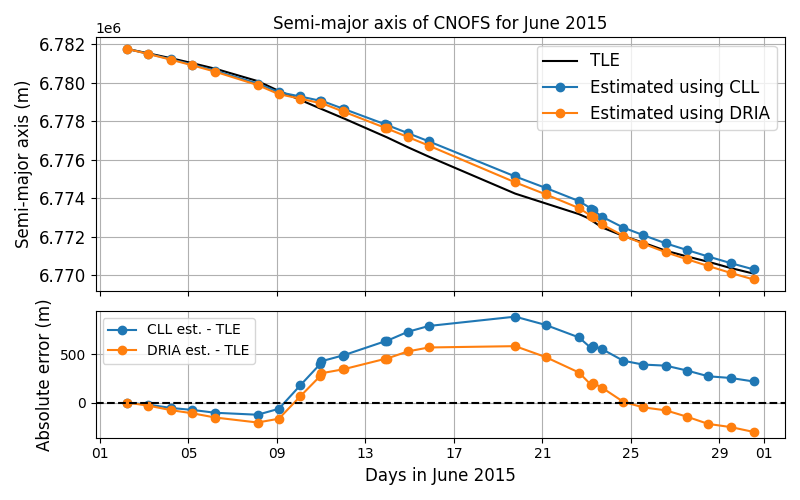

In [66]:
fig,ax1 = plt.subplots(2,1,figsize=[8,5],sharex=True,gridspec_kw={'height_ratios': [2,1]})
ax1[0].plot(epochs,sma,c='k',label='TLE')
ax1[0].plot(epochs,sma_est_CLL,'-o',label='Estimated using CLL')
ax1[0].plot(epochs,sma_est_DRIA,'-o',label='Estimated using DRIA')
ax1[0].legend(fontsize=12)
ax1[0].set_ylabel('Semi-major axis (m)',fontsize=12)
# ax1[0].set_xlabel('Days in June 2015')
ax1[0].tick_params(labelsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(daysFmt);
ax1[0].set_title('Semi-major axis of CNOFS for June 2015')
ax1[0].grid()
ax1[1].plot(epochs,sma_est_CLL-sma,'-o',label = 'CLL est. - TLE')
ax1[1].plot(epochs,sma_est_DRIA-sma,'-o',label = 'DRIA est. - TLE')
ax1[1].axhline(y=0,ls='--',lw=1.5,c='k')
ax1[1].legend(loc='upper left')
ax1[1].set_ylabel('Absolute error (m)',fontsize=12)
ax1[1].set_xlabel('Days in June 2015',fontsize=12)
ax1[1].grid()

plt.tight_layout()
plt.show()

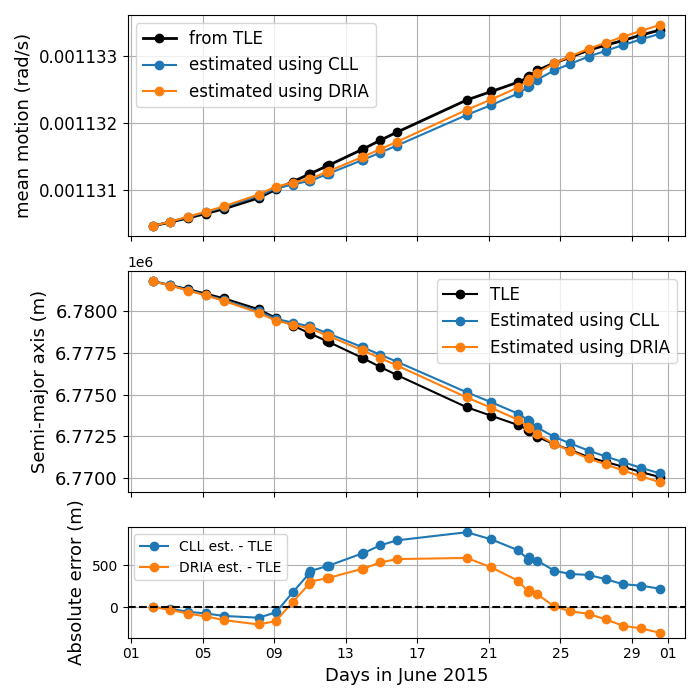

In [68]:
fig,ax = plt.subplots(3,1,figsize=[7,7],gridspec_kw={'height_ratios': [2,2,1]},sharex=True)
ax[0].plot(epochs,n,'-o',c='k',label='from TLE',lw=2)
ax[0].plot(epochs,n_est_CLL,'-o',label='estimated using CLL')
ax[0].plot(epochs,n_est_DRIA,'-o',label='estimated using DRIA')
ax[0].legend(fontsize=12)
ax[0].set_ylabel('mean motion (rad/s)',fontsize=13)
# ax[0].set_xlabel('Days in August 2005')
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_formatter(daysFmt);
# ax[0].set_title('Mean motion of GRACE for August 2005',fontsize=15)
ax[0].grid()

ax[1].plot(epochs,sma,'-o',c='k',label='TLE')
ax[1].plot(epochs,sma_est_CLL,'-o',label='Estimated using CLL')
ax[1].plot(epochs,sma_est_DRIA,'-o',label='Estimated using DRIA')
ax[1].legend(fontsize=12)
ax[1].set_ylabel('Semi-major axis (m)',fontsize=13)
# ax[0].set_xlabel('Days in August 2005')
ax[1].tick_params(labelsize=13)
ax[1].grid()
ax[1].xaxis.set_major_formatter(daysFmt);

ax[2].plot(epochs,sma_est_CLL-sma,'-o',label = 'CLL est. - TLE',c='tab:blue')
ax[2].plot(epochs,sma_est_DRIA-sma,'-o',label = 'DRIA est. - TLE',c='tab:orange')
ax[2].axhline(y=0,ls='--',lw=1.5,c='k')
ax[2].legend(loc='best')
ax[2].set_ylabel('Absolute error (m)',fontsize=13)
ax[2].set_xlabel('Days in June 2015',fontsize=13)
ax[2].grid()
# ax1[0].set_title('Semi-major axis of GRACE for August 2005',fontsize=13)
plt.tight_layout()
plt.show()


# $C_D$ sensitivity

In [78]:
# n0 = np.mean(Data_MSIS.iloc[:,2:8].sum(axis=1))
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
X = np.arange(0.0,1.001,0.0025);
n0 = 3.0e13;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case1 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

In [79]:
# n0 = np.mean(Data_MSIS.iloc[:,2:8].sum(axis=1))
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
X = np.arange(0.0,1.001,0.0025);
n0 = 1.0e14;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_DRIA([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_CNOFS_CLL([v0,0,0],R_H,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case2 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}


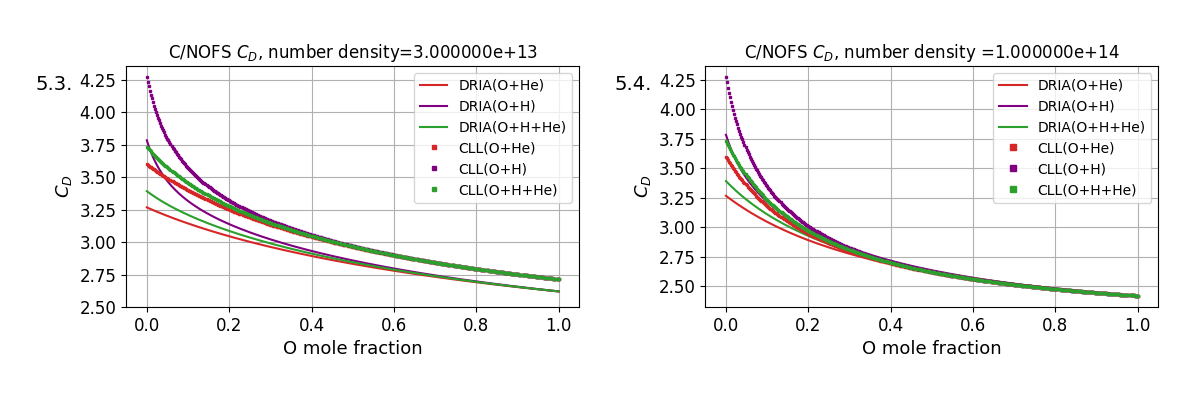

In [84]:
fig,ax = plt.subplots(1,2,figsize=[12,4])
ax[0].plot(X,case1['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[0].plot(X,case1['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[0].plot(X,case1['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[0].plot(X,case1['CD_CLL_1'],'s',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[0].plot(X,case1['CD_CLL_2'],'s',ms=1.5,label='CLL(O+H)',c='purple')
ax[0].plot(X,case1['CD_CLL_3'],'s',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[0].set_xlabel('O mole fraction',fontsize=13)
ax[0].set_ylabel('$C_D$',fontsize=13)
ax[0].legend(loc='best',markerscale=2)
ax[0].set_title(r'C/NOFS $C_{D}$, number density=' + "{:e}".format(case1['n0']),fontsize=12)

ax[1].plot(X,case2['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[1].plot(X,case2['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[1].plot(X,case2['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[1].plot(X,case2['CD_CLL_1'],'s',ms=1.5,label='CLL(O+He)',c='tab:red')
ax[1].plot(X,case2['CD_CLL_2'],'s',ms=1.5,label='CLL(O+H)',c='purple')
ax[1].plot(X,case2['CD_CLL_3'],'s',ms=1.5,label='CLL(O+H+He)',c='tab:green')

ax[1].set_xlabel('O mole fraction',fontsize=13)
ax[1].set_ylabel('$C_D$',fontsize=13)
ax[1].legend(loc='best',markerscale=3)
ax[1].set_title(r'C/NOFS $C_{D}$, number density =' + "{:e}".format(case2['n0']),fontsize=12)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].text(-0.2, 0.9, "5.3.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[1].text(-0.2, 0.9, "5.4.", transform=ax[1].transAxes, fontsize=14, color='k')

ax[0].set_yticks(np.arange(2.5,4.5,0.25))
ax[1].set_yticks(np.arange(2.5,4.5,0.25))



ax[0].grid(which='both')
ax[1].grid(which='both')
plt.tight_layout(pad=3.0)


filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CNOFS_CD_sens_1.jpg";
plt.savefig(filename,format='jpg',dpi=1200)
plt.show()

In [82]:
np.array(case2['CD_CLL_1']).max()/np.array(case2['CD_CLL_1']).min(),np.array(case2['CD_CLL_2']).max()/np.array(case2['CD_CLL_2']).min(),np.array(case2['CD_CLL_3']).max()/np.array(case2['CD_CLL_3']).min()

(1.4867125888002035, 1.7652567649103135, 1.5424214240222256)

In [83]:
np.array(case2['CD_DRIA_1']).max()/np.array(case2['CD_DRIA_1']).min(),np.array(case2['CD_DRIA_2']).max()/np.array(case2['CD_DRIA_2']).min(),np.array(case2['CD_DRIA_3']).max()/np.array(case2['CD_DRIA_3']).min()

(1.351120754068325, 1.5648527217283723, 1.402814442187158)

In [112]:
# n0 = np.mean(Data_MSIS.iloc[:,2:9].sum(axis=1))
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];

O_He = np.arange(0.2,1.001,0.0025);
temp = np.arange(500,2001,2.5);
X,Y = np.meshgrid(O_He,temp);
X=X.ravel(); Y=Y.ravel();

In [113]:
CD_DRIA = np.zeros((len(O_He),len(temp)));
CD_CLL = np.zeros((len(O_He),len(temp)));

for i,x in tqdm(enumerate(O_He)):
    for j,y in enumerate(temp): 
        m_avg = m_O*x + m_He*(1-x)
        nO = n0*x

        CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,y,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,y,m_avg,nO,T_s0,a,n_a)
        CD_DRIA[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg

        CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,y,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_CNOFS_CLL([v0,0,0],R_He,y,m_avg,nO,T_s0,a,n_a)
        CD_CLL[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
        
CD_DRIA = np.transpose(CD_DRIA)
CD_CLL= np.transpose(CD_CLL)

321it [27:29,  5.14s/it]


In [138]:
(np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)

0.21223330516049074

In [133]:
np.min((np.max(CD_CLL,axis=1)-np.min(CD_CLL,axis=1))*100/np.mean(CD_CLL,axis=1))

18.74599581299806

In [135]:
np.max((np.max(CD_DRIA,axis=1)-np.min(CD_DRIA,axis=1))*100/np.mean(CD_DRIA,axis=1))

18.887823503794962

In [117]:
# (CD_DRIA[-1,:] - CD_DRIA[0,:])/np.mean(CD_DRIA,axis=0)
# (CD_CLL[-1,:] - CD_CLL[0,:])/np.mean(CD_CLL,axis=0)
# (CD_CLL[:,-1] - CD_CLL[:,0])/np.mean(CD_CLL,axis=1)
# (CD_DRIA[:,-1] - CD_DRIA[:,0])/np.mean(CD_DRIA,axis=1)


In [ ]:
# (CD_CLL[:,0] - CD_CLL[:,-1])/np.mean(CD_CLL,axis=1)
# (np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)
# x00 = (np.max(CD_DRIA,axis=0)-np.min(CD_DRIA,axis=0))/np.mean(CD_DRIA,axis=0)
# x01 = (np.max(CD_DRIA,axis=1)-np.min(CD_DRIA,axis=1))/np.mean(CD_DRIA,axis=1)
# (CD_DRIA[-1,:] - CD_DRIA[0,:])/np.mean(CD_DRIA,axis=0)
# (CD_CLL[-1,:] - CD_CLL[0,:])/np.mean(CD_CLL,axis=0)
# (CD_CLL[:,-1] - CD_CLL[:,0])/np.mean(CD_CLL,axis=1)
# (CD_DRIA[:,-1] - CD_DRIA[:,0])/np.mean(CD_DRIA,axis=1)
# (np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)
# (np.max(CD_CLL)-np.min(CD_CLL))/np.mean(CD_CLL)

In [15]:
# (np.max(CD_DRIA,axis=1) - np.min(CD_DRIA,axis=1))*100/np.mean(CD_DRIA,axis=1)

In [16]:
# (np.max(CD_CLL,axis=1) - np.min(CD_CLL,axis=1))*100/np.mean(CD_CLL,axis=1)

In [139]:
# idx = np.where(X >= 0.2)[0];
idx = np.arange(0,len(X))

# X=X[idx]; Y = Y[idx]; CD_DRIA=np.array(CD_DRIA)[idx]; CD_CLL=np.array(CD_CLL)[idx];

In [140]:
CD_DRIA = CD_DRIA.ravel()
CD_CLL = CD_CLL.ravel()

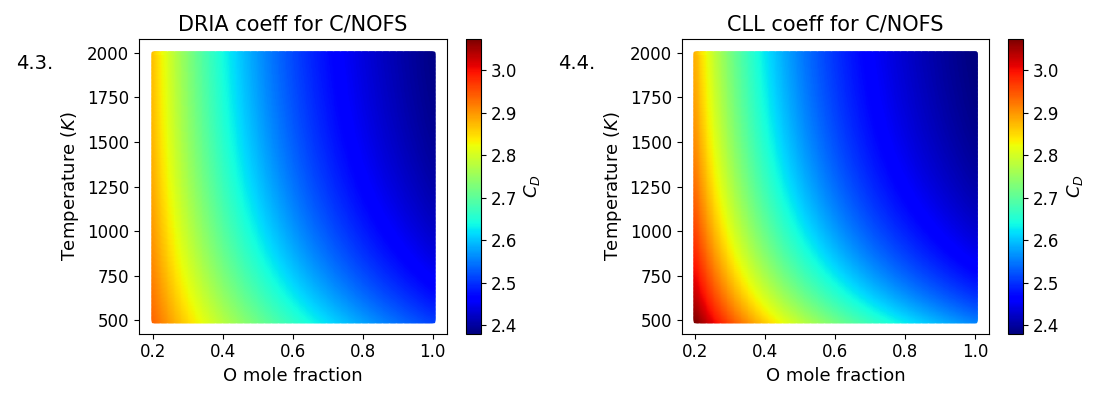

In [141]:
fig,ax = plt.subplots(1,2,figsize=[11,4],sharey=False)

vmin = np.min([np.min(CD_DRIA[idx]),np.min(CD_CLL[idx])])
vmax = np.max([np.max(CD_DRIA[idx]),np.max(CD_CLL[idx])])

f0 = ax[0].scatter(X[idx],Y[idx],s=3,marker='s',c=CD_DRIA[idx],cmap='jet',vmin=vmin,vmax=vmax)
ax[0].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[0].set_xlabel('O mole fraction',fontsize=13)
ax[0].set_title("DRIA coeff for C/NOFS",fontsize=15)
ax[0].tick_params(labelsize=12)
cbar = fig.colorbar(f0,ax=ax[0],label='$C_D$')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r'$C_{D}$', size=13, weight='bold')

f1 = ax[1].scatter(X[idx],Y[idx],s=3,marker='s',c=CD_CLL[idx],cmap='jet',vmin=vmin,vmax=vmax)
# ax[1].set_ylabel('Temperature')
ax[1].set_xlabel('O mole fraction',fontsize=13)
ax[1].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[1].tick_params(labelsize=12)
ax[1].set_title("CLL coeff for C/NOFS",fontsize=15)
cbar = fig.colorbar(f1,ax=ax[1],label='$C_D$')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label=r'$C_{D}$', size=13, weight='bold')

ax[0].text(-0.4, 0.9, "4.3.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[1].text(-0.4, 0.9, "4.4.", transform=ax[1].transAxes, fontsize=14, color='k')


plt.tight_layout()
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath)
plt.savefig("CNOFS_CD_sens_0.jpg",format='jpg',dpi=1200)
plt.show()  

In [111]:
(CD_DRIA[-1,:] - CD_DRIA[0,:])/np.mean(CD_DRIA,axis=0)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# (CD_DRIA[-1,:] - CD_DRIA[0,:])/np.mean(CD_DRIA,axis=0)
# (CD_CLL[-1,:] - CD_CLL[0,:])/np.mean(CD_CLL,axis=0)
# (CD_CLL[:,-1] - CD_CLL[:,0])/np.mean(CD_CLL,axis=1)
# (CD_DRIA[:,-1] - CD_DRIA[:,0])/np.mean(CD_DRIA,axis=1)
# (np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)
# (np.max(CD_CLL)-np.min(CD_CLL))/np.mean(CD_CLL)

In [8]:
# n0 = np.mean(Data_MSIS.iloc[:,2:8].sum(axis=1))
v0 = 7500;
T_s0 = 300;
temp0 = 1100;
x0 = 1.0
n = np.logspace(12,15,100,base=10)

## Case 1: O + He
CD_DRIA_1 = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_DRIA_1.append(CD)
    
    
## Case 1: O + He
CD_CLL_1 = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_CLL_1.append(CD)
    


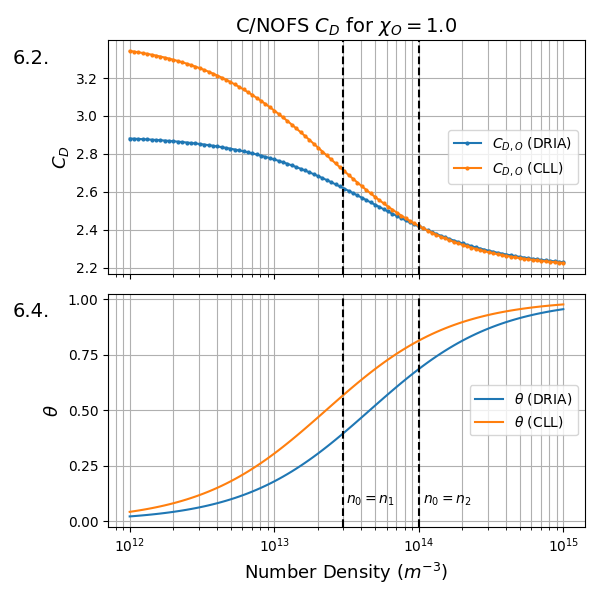

In [9]:
Po = n*k_B*temp0
fig,ax = plt.subplots(2,1,sharex=True,figsize=[6,6])
ax[0].plot(n,CD_DRIA_1,'-o',ms=2,label=r'$C_{D,O}$ (DRIA)')
ax[0].plot(n,CD_CLL_1,'-o',ms=2,label=r'$C_{D,O}$ (CLL)')
ax[0].set_xscale('log')
ax[0].set_ylabel('$C_{D}$',fontsize=13)
ax[0].legend(loc='center right')
ax[0].set_title(r'C/NOFS $C_{D}$ for $\chi_{O} = 1.0$',fontsize=14)
ax[0].axvline(x=3.0e13,ls='--',c='k')
ax[0].axvline(x=1e14,ls='--',c='k')
ax[0].text(-0.2, 0.9, "6.2.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[0].grid(which='both')


theta_DRIA = 1.44*10**6*Po/(1 + 1.44*10**6*Po)
theta_CLL = 2.89*10**6*Po/(1 + 2.89*10**6*Po)

ax[1].plot(n,theta_DRIA,label=r'$\theta$ (DRIA)')
ax[1].plot(n,theta_CLL,label=r'$\theta$ (CLL)')
ax[1].set_ylabel(r'$\theta$',fontsize=13)
ax[1].set_xlabel(r'Number Density ($m^{-3}$)',fontsize=13)
ax[1].axvline(x=3.0e13,ls='--',c='k')
ax[1].axvline(x=1e14,ls='--',c='k')
ax[1].set_yticks([0.0,0.25,0.50,0.75,1.0]);
ax[1].text(0.5, 0.1, r"$n_{0}=n_{1}$", transform=ax[1].transAxes, fontsize=10, color='k',weight='bold')
ax[1].text(0.66, 0.1, r"$n_{0}=n_{2}$", transform=ax[1].transAxes, fontsize=10, color='k',weight='bold')
ax[1].grid(which='both')
ax[1].text(-0.2, 0.9, "6.4.", transform=ax[1].transAxes, fontsize=14, color='k')
ax[1].legend(loc='center right')

plt.tight_layout()

filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CNOFS_CD_sens_2.jpg";
plt.savefig(filename,format='jpg',dpi=1200)
plt.show()

## wrt pitch and yaw angle

In [98]:
n0 = 1.0e14
v0 = 7500;
T_s0 = 300; temp0 = 1100;
CD_CLL=[]; CD_DRIA=[];

pitch = np.deg2rad(np.linspace(-2,2,300));
yaw = np.deg2rad(np.linspace(-5,5,300));

X,Y = np.meshgrid(yaw,pitch);
X=X.ravel(); Y=Y.ravel();

frac_O = 1.0; frac_He = 1 - frac_O;
m_avg = frac_O*m_O + frac_He*m_He
nO = n0*frac_O

In [99]:
for i in tqdm(range(len(X))):
    vel = [v0*cos(Y[i])*cos(X[i]),v0*cos(Y[i])*sin(X[i]),v0*sin(Y[i])]
    
    CD_O =  drag_CNOFS_DRIA(vel,R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_DRIA(vel,R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_DRIA.append(CD)
    
    CD_O =  drag_CNOFS_CLL(vel,R_O,temp0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_CNOFS_CLL(vel,R_He,temp0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_CLL.append(CD)

100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [13:09<00:00, 114.02it/s]


In [100]:
CD_O =  drag_CNOFS_DRIA([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
CD_He = drag_CNOFS_DRIA([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
CD_DRIA_0 = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg


CD_O =  drag_CNOFS_CLL([v0,0,0],R_O,temp0,m_avg,nO,T_s0,a,n_a)
CD_He = drag_CNOFS_CLL([v0,0,0],R_He,temp0,m_avg,nO,T_s0,a,n_a)
CD_CLL_0 = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg

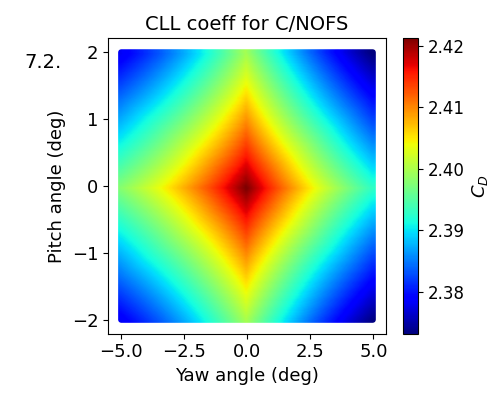

In [103]:
fig,ax = plt.subplots(1,1,figsize=[5,4],sharey=False)

# f0 = ax[0].scatter(np.rad2deg(X),np.rad2deg(Y),s=5,c=CD_DRIA,cmap='jet')
# ax[0].set_ylabel('Pitch angle (deg)',fontsize=13)
# ax[0].set_xlabel('Yaw angle (deg)',fontsize=13)
# ax[0].set_title("DRIA coeff for C/NOFS",fontsize=15)
# ax[0].tick_params(labelsize=13)
# cbar = fig.colorbar(f0,ax=ax[0],label=r'$C_{D}$')
# cbar.set_label(label=r'$C_{D}$', size='large', weight='bold')
# cbar.ax.tick_params(labelsize=12)


f1 = ax.scatter(np.rad2deg(X),np.rad2deg(Y),s=5,c=CD_CLL,cmap='jet')
ax.set_xlabel('Yaw angle (deg)',fontsize=13)
ax.set_ylabel('Pitch angle (deg)',fontsize=13)

ax.set_title("CLL coeff for C/NOFS",fontsize=14)
ax.tick_params(labelsize=13)
ax.text(-0.3, 0.9, "7.2.", transform=ax.transAxes, fontsize=14, color='k')

cbar=fig.colorbar(f1,ax=ax,label=r'$C_{D}$')
cbar.set_label(label=r'$C_{D}$', size=13, weight='bold')
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
plt.savefig("CNOFS_CD_sens_3.jpg",format='jpg',dpi=1200)
plt.show()

In [102]:
np.max(CD_DRIA)/np.min(CD_DRIA)

1.019530304678029

In [12]:
# def rodrigues_rotation(v,k,theta):
#     ## v = vector, k = unit vector defining rotation axis
#     ## theta = angle of rotation (in deg)
#     v = np.array(v); k = np.array(k);
#     theta = theta*pi/180 ## convert in radian
#     return v*cos(theta) + np.cross(k,v)*sin(theta) + k*dot(k,v)*(1-cos(theta))
# v = (1,0,0); k = (0,0,1); theta = 90

7197.013486299676

In [7]:
# c=1/sqrt(2); c1=0.96592583; c2=0.25881905; c3=0.6830127;
# theta = pi/10; 

# a = [0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,
#     0.579,0.579,0.579,0.579,0.579,0.579,0.579,0.579,
#     0.142,0.142,0.142,0.142,0.142,0.142,0.142,0.142,
#     0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,
#     0.455,1,
#      0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
#      0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078, 
#      0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
#      0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
#      0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,
#     0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924];

# n_a = [(1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
#       (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
#       (c1,-c2,0),(c3,-c2,c3),(0,-c2,c1),(-c3,-c2,c3),(-c1,-c2,0),(-c3,-c2,-c3),(0,-c2,-c1),(c3,-c2,-c3),
#       (cos(-theta),0,sin(-theta)),(cos(-3*theta),0,sin(-3*theta)),(cos(-5*theta),0,sin(-5*theta)),(cos(-7*theta),0,sin(-7*theta)),(cos(-9*theta),0,sin(-9*theta)),
#       (cos(-11*theta),0,sin(-11*theta)),(cos(-13*theta),0,sin(-13*theta)),(cos(-15*theta),0,sin(-15*theta)),(cos(-17*theta),0,sin(-17*theta)),
#        (cos(-19*theta),0,sin(-19*theta)),(0,-1,0),(0,1,0),
#       (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 1
#        (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 2
#        (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 3
#        (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 4
#       (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c), ## boom 5
#       (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c)]; ## boom 6

